<a href="https://colab.research.google.com/github/noburooney/Signal_Processing/blob/main/Fourier_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier transform

## （準備）デモ用のsignalを作成

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

pi = math.pi

デモのため、３つのsine波を足し合わせたsignalを作ります

In [2]:
#Given that time points = 1024,  sampling_rate = 1024
pnts = 1024
srate = 512
t = np.arange(0, pnts)/srate

一つずつ表示してみる

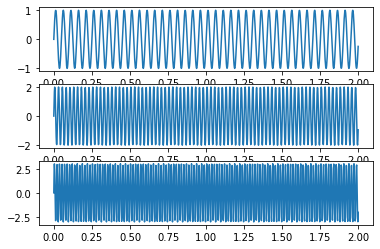

In [3]:
#creating 3 different sine waves
frex = [20, 40, 60]
amp = [1, 2, 3]

sine1 = amp[0] * np.sin(2*pi*frex[0]*t)
sine2 = amp[1] * np.sin(2*pi*frex[1]*t)
sine3 = amp[2] * np.sin(2*pi*frex[2]*t)

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, sine1)

ax2 = fig.add_subplot(312)
ax2.plot(t, sine2)

ax3 = fig.add_subplot(313)
ax3.plot(t, sine3)

３つのsine波の和で得られるsignalをプロットしてみます。

Text(0, 0.5, 'Amplitude (μV)')

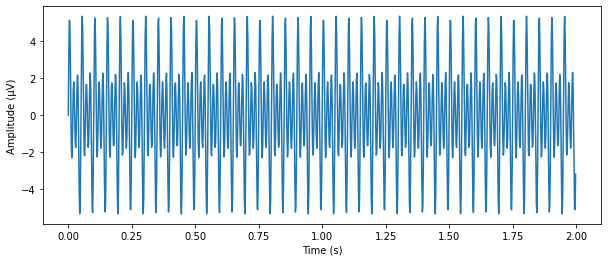

In [4]:
#then, add them together
signal = sine1 + sine2 + sine3

#signal = 10 * np.sin(2*pi*20*t)

plt.figure(figsize=(10,4))
plt.plot(t, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')

## フーリエ変換の実行

scipy.fftpack.fftを使って、フーリエ係数を求めます。 


In [5]:
FourierCoefs = fft(signal)

# show some Fourier coefficients
print(FourierCoefs[:2])
# The number of Fourier coefficients are equal to the number of time points
print(FourierCoefs.shape)

[-1.55366026e-12-0.00000000e+00j  1.53002246e-13-1.11760904e-12j]
(1024,)


Scaling せずにプロットしてみます。

Cohenのレクチャー通り、ナイキスト周波数を挟んで左右対称になっています(positive and negative frequencies)。フーリエ変換で得られる周波数はsampling rateの半分までであることを思い出しましょう。

また、20, 40, 60 HzのAmplitudeも実際とはかけ離れた値になっています。

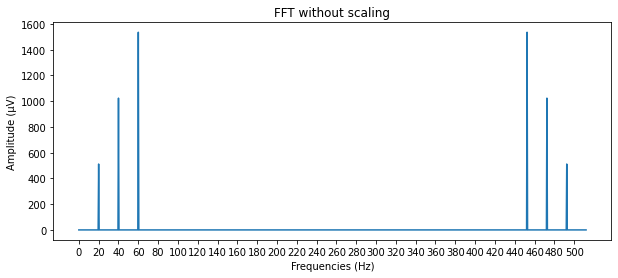

In [6]:
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, srate, pnts), np.abs(FourierCoefs))
plt.title("FFT without scaling")
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Amplitude (μV)')
plt.xticks(np.arange(0, srate, 20))

plt.show()

正しくスケーリングしたい場合は、以下の２点に気をつける

- フーリエ係数をtime pointの数で割る
- negative frequency (ナイキスト以上の周波数)のAmplitudeを、positive frequencyのAmplitudeに足す（左右対称なので、実際には２倍すれば良い）

＊厳密には、0 Hzとナイキストのフーリエ係数は、negative frequencyの領域に存在しないので、２倍してはいけないが、実際の解析では、気にしないことが多い(by Cohen)。また、正しくscalingしてもしなくても、スペクトラムの形自体は同じなので、scalingを行わないこともしばしばである。


In [7]:
FourierCoefs = fft(signal) / pnts
Amplitude = 2 * np.abs(FourierCoefs)
frequencies = np.linspace(0, srate/2, math.floor(pnts/2)+1)

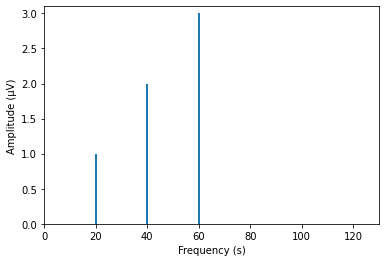

In [8]:
plt.bar(frequencies, Amplitude[:frequencies.shape[0]])
plt.xlim([0, 130])
plt.ylim([0, 3.1])
plt.xlabel('Frequency (s)')
plt.ylabel('Amplitude (μV)')

plt.show()
# note the amplitude scale matches the original signal

Inverse Fourier transformにより、フーリエ係数から元のsignalを再構築

Text(0, 0.5, 'Amplitude (μV)')

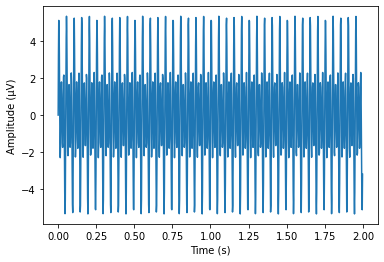

In [9]:
recon_signal = ifft(FourierCoefs) * pnts
# Do not forget to multiply by time points. You have devided Fourier coefficients by time points, remember?

plt.plot(t, np.real(recon_signal))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')

## Effect of zero-padding

フーリエ変換で得られる周波数は、0 ~ srate/2 [hz]の、timepoint/2+1個である。

よって、周波数「解像度」は、
- sampling rate
- time point

に依存する。
sampling rateは後からどうしようもないので、よく行われる手法として、「zero padding」という方法がある。これは、signalの後に[0, 0, 0, 0, 0, ....]のように0を付け加えることにより、time pointを稼ごうという手法である。

scipy.fftpack.fftの第２引数には、データの長さを指定でき、実際のデータより長い値を入れた場合、自動的にzero paddingが行われる。

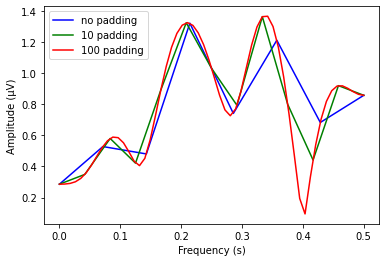

In [10]:
#zero_padding
signal_2 = [1, 0, 1, 2, -3, 1, 2, 0, -3, 0, -1, 2, 1, -1]


signalX1 = fft(signal_2)                    / len(signal_2)
signalX2 = fft(signal_2, len(signal_2)+10)  / len(signal_2)
signalX3 = fft(signal_2, len(signal_2)+100) / len(signal_2)

freq1 = np.linspace(0, 0.5, math.floor(len(signalX1)/2)+1)
freq2 = np.linspace(0, 0.5, math.floor(len(signalX2)/2)+1)
freq3 = np.linspace(0, 0.5, math.floor(len(signalX3)/2)+1)

plt.plot(freq1, 2 * np.abs( signalX1[:len(freq1)] ), color='blue', label='no padding')
plt.plot(freq2, 2 * np.abs( signalX2[:len(freq2)] ), color='green', label='10 padding')
plt.plot(freq3, 2 * np.abs( signalX3[:len(freq3)] ), color='red', label='100 padding')
plt.xlabel('Frequency (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()

# more padding, more smoother

## Weich's method

フーリエ変換では、non-stationaryなデータに対して、正しく計算することができないというデメリットがある。そこで考案されたのが、Welch法という手法である。
これは、
- まずデータの断片（snippet）を切り出す
- edge articactをへらすためにテーパリングする（Hann taperingを用いることが多い）
- snippetをフーリエ変換し、同様にして得られた全snippetのスペクトラムを平均する

という方法である（詳しくはCohenのlectureを参照）

Welch法は、non-stationaryなデータに対して多少耐えうることができ、また、noiseの影響を受けにくいというメリットがあるが、snippetに切り出すことにより、time pointが短くなるので、周波数の解像度を犠牲にしてしまう。

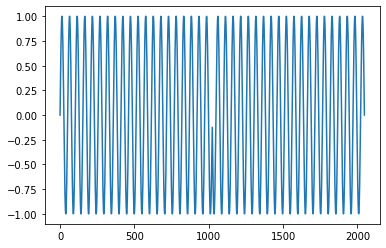

In [11]:
from scipy import signal

# First, let's create a non-stationary signal
y = np.sin(2*pi*10*t)
y_ = y[::-1]

non_stat_signal = np.concatenate([y, y_],axis=0)
plt.plot(non_stat_signal)
plt.show()

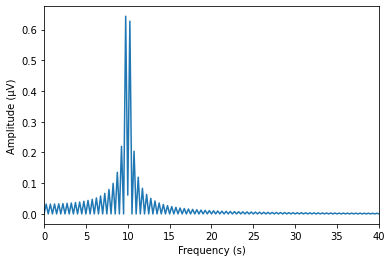

In [12]:
#Then, apply usual FFT... the result is very strange...
freqs = np.linspace(0, srate/2, math.floor(len(non_stat_signal)/2+1))
fc = 2 * abs(fft(non_stat_signal)) / len(non_stat_signal)

plt.plot(freqs, fc[:len(freqs)])
plt.xlim([0, 40])
plt.xlabel('Frequency (s)')
plt.ylabel('Amplitude (μV)')
plt.show()


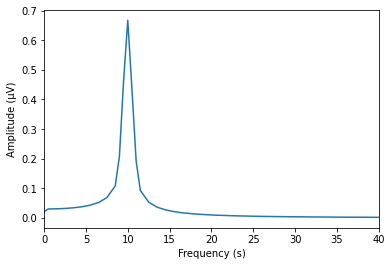

In [13]:
# Finally, Welch's method: y axis is Power
# Although better than usual FFT, note that the amplitude scaling is still not perfect. 
freq, pxx = signal.welch(non_stat_signal, srate, nperseg=len(non_stat_signal)/2)
plt.plot(freq, np.sqrt(pxx))
plt.xlim([0, 40])
plt.xlabel('Frequency (s)')
plt.ylabel('Amplitude (μV)')
plt.show()